<a href="https://colab.research.google.com/github/astralcai/music-genre-classification/blob/master/attention_rnn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from google.colab import drive
import pickle
drive.mount('/content/drive/', force_remount=True)

TensorFlow 2.x selected.
Mounted at /content/drive/


In [0]:
spectrograms = pickle.load(open('/content/drive/My Drive/mgc_dataset/Copy of gtzan_spectrograms_3_1024.p', 'rb'))
labels = pickle.load(open('/content/drive/My Drive/mgc_dataset/Copy of gtzan_labels_3_1024.p', 'rb'))

In [3]:
spectrograms = np.transpose(spectrograms, axes=(0,2,1))  # put time on the x-axis
data_shape = spectrograms.shape[1:]
print(data_shape)

(128, 513)


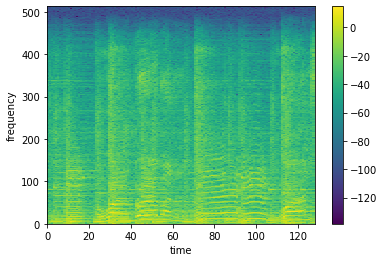

In [4]:
import matplotlib.pyplot as plt
plt.pcolormesh(np.linspace(0,data_shape[0],data_shape[0]), np.linspace(0,data_shape[1],data_shape[1]), 10*np.log10(spectrograms[0]).T)
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar()
plt.show()

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score , recall_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(spectrograms, labels, test_size=0.2)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=5)
print(y_train.shape, y_test.shape)

(3618, 5) (905,)


In [0]:
def make_rnn():

  input_layer = layers.Input(shape=(data_shape[0], data_shape[1]), name="input")
  input_extended = tf.keras.backend.expand_dims(input_layer)

  # BGRU data flow
  rnn_layer_1 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_1")(input_layer)
  rnn_layer_2 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_2")(rnn_layer_1)
  # brnn = layers.concatenate([rnn_layer_1, rnn_layer_2], name="BGRU_output")

  # decoder
  average_layer = layers.AveragePooling2D(pool_size=(128,1))(tf.keras.backend.expand_dims(rnn_layer_2))
  # hidden_layer = layers.Dense(units=64, activation="relu")(layers.Flatten()(average_layer))
  classifier = layers.Dense(units=5, activation="softmax")(layers.Flatten()(average_layer))
  model = Model(inputs=input_layer, outputs=classifier)
  return model

def make_rnn_attention():

  input_layer = layers.Input(shape=(data_shape[0], data_shape[1]), name="input")
  input_extended = tf.keras.backend.expand_dims(input_layer)

  # BGRU data flow
  rnn_layer_1 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_1")(input_layer)
  rnn_layer_2 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_2")(rnn_layer_1)
  # brnn = layers.concatenate([rnn_layer_1, rnn_layer_2], name="BGRU_output")

  # CNN attention network
  dropout = layers.Dropout(0.2)
  conv_1 = layers.Conv2D(32, 3, padding="same", name="conv_1", activation='relu')(dropout(input_extended))
  pool_1 = layers.MaxPool2D(pool_size=(2,2))(conv_1)
  conv_2 = layers.Conv2D(32, 3, padding="same", name="conv_2", activation='relu')(dropout(pool_1))
  pool_2 = layers.MaxPool2D(pool_size=(2,2))(conv_2)
  conv_3 = layers.Conv2D(64, 3, padding="same", name="conv_3", activation='relu')(dropout(pool_2))
  pool_3 = layers.MaxPool2D(pool_size=(2,2))(conv_3)
  conv_4 = layers.Conv2D(128, 3, padding="same", name="conv_4", activation='relu')(dropout(pool_3))
  pool_4 = layers.MaxPool2D(pool_size=(4,4))(conv_4)
  conv_5 = layers.Conv2D(64, 3, padding="same", name="conv_5", activation='relu')(dropout(pool_4))
  pool_5 = layers.MaxPool2D(pool_size=(4,4))(conv_5)
  scores = layers.Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers.Flatten()(pool_5))

  # decoder
  fusion_layer = layers.Dot((1,1))([rnn_layer_2, tf.keras.backend.expand_dims(scores)])
  # hidden_layer = layers.Dense(units=64, activation="relu")(layers.Flatten()(fusion_layer))
  classifier = layers.Dense(units=5, activation="softmax")(layers.Flatten()(fusion_layer))
  model = Model(inputs=input_layer, outputs=classifier)

  return model

def make_cnn():

  input_layer = layers.Input(shape=(data_shape[0], data_shape[1]), name="input")
  input_extended = tf.keras.backend.expand_dims(input_layer)

  # CNN attention network
  dropout = layers.Dropout(0.2)
  conv_1 = layers.Conv2D(32, 3, padding="same", name="conv_1", activation='relu')(dropout(input_extended))
  pool_1 = layers.MaxPool2D(pool_size=(2,2))(conv_1)
  conv_2 = layers.Conv2D(32, 3, padding="same", name="conv_2", activation='relu')(dropout(pool_1))
  pool_2 = layers.MaxPool2D(pool_size=(2,2))(conv_2)
  conv_3 = layers.Conv2D(64, 3, padding="same", name="conv_3", activation='relu')(dropout(pool_2))
  pool_3 = layers.MaxPool2D(pool_size=(2,2))(conv_3)
  conv_4 = layers.Conv2D(128, 3, padding="same", name="conv_4", activation='relu')(dropout(pool_3))
  pool_4 = layers.MaxPool2D(pool_size=(4,4))(conv_4)
  conv_5 = layers.Conv2D(64, 3, padding="same", name="conv_5", activation='relu')(dropout(pool_4))
  pool_5 = layers.MaxPool2D(pool_size=(4,4))(conv_5)
  scores = layers.Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers.Flatten()(pool_5))

  classifier = layers.Dense(units=5, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))(scores)
  model = Model(inputs=input_layer, outputs=classifier)
  return model

def make_parallel_cnn_rnn():

  input_layer = layers.Input(shape=(data_shape[0], data_shape[1]), name="input")
  input_extended = tf.keras.backend.expand_dims(input_layer)

  # BGRU data flow
  rnn_layer_1 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_1")(input_layer)
  rnn_layer_2 = layers.Bidirectional(layers.GRU(units=256, return_sequences=True, dropout=0.3), name="BGRU_2")(rnn_layer_1)
  # brnn = layers.concatenate([rnn_layer_1, rnn_layer_2], name="BGRU_output")

  # CNN attention network
  # dropout = layers.Dropout(0.2)
  # conv_1_attention = layers.Conv2D(32, 3, padding="same", activation='relu')(dropout(input_extended))
  # pool_1_attention = layers.MaxPool2D(pool_size=(2,2))(conv_1_attention)
  # conv_2_attention = layers.Conv2D(32, 3, padding="same", activation='relu')(dropout(pool_1_attention))
  # pool_2_attention = layers.MaxPool2D(pool_size=(2,2))(conv_2_attention)
  # conv_3_attention = layers.Conv2D(64, 3, padding="same", activation='relu')(dropout(pool_2_attention))
  # pool_3_attention = layers.MaxPool2D(pool_size=(2,2))(conv_3_attention)
  # conv_4_attention = layers.Conv2D(128, 3, padding="same", activation='relu')(dropout(pool_3_attention))
  # pool_4_attention = layers.MaxPool2D(pool_size=(4,4))(conv_4_attention)
  # conv_5_attention = layers.Conv2D(64, 3, padding="same", activation='relu')(dropout(pool_4_attention))
  # pool_5_attention = layers.MaxPool2D(pool_size=(4,4))(conv_5_attention)
  # scores_attention = layers.Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers.Flatten()(pool_5_attention))

  # CNN network
  dropout = layers.Dropout(0.2)
  conv_1 = layers.Conv2D(32, 3, padding="same", name="conv_1", activation='relu')(dropout(input_extended))
  pool_1 = layers.MaxPool2D(pool_size=(2,2))(conv_1)
  conv_2 = layers.Conv2D(32, 3, padding="same", name="conv_2", activation='relu')(dropout(pool_1))
  pool_2 = layers.MaxPool2D(pool_size=(2,2))(conv_2)
  conv_3 = layers.Conv2D(64, 3, padding="same", name="conv_3", activation='relu')(dropout(pool_2))
  pool_3 = layers.MaxPool2D(pool_size=(2,2))(conv_3)
  conv_4 = layers.Conv2D(128, 3, padding="same", name="conv_4", activation='relu')(dropout(pool_3))
  pool_4 = layers.MaxPool2D(pool_size=(4,4))(conv_4)
  conv_5 = layers.Conv2D(64, 3, padding="same", name="conv_5", activation='relu')(dropout(pool_4))
  pool_5 = layers.MaxPool2D(pool_size=(4,4))(conv_5)
  scores = layers.Dense(units=512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers.Flatten()(pool_5))

  # decoder
  # average_layer = layers.Dot((1,1))([rnn_layer_2, tf.keras.backend.expand_dims(scores_attention)])
  average_layer = layers.AveragePooling2D(pool_size=(128,1))(tf.keras.backend.expand_dims(rnn_layer_2))
  fusion_layer = layers.concatenate([layers.Flatten()(average_layer), scores])
  hidden_layer = layers.Dense(units=90, activation="relu")(layers.Flatten()(fusion_layer))
  classifier = layers.Dense(units=5, activation="softmax")(layers.Flatten()(hidden_layer))
  model = Model(inputs=input_layer, outputs=classifier)
  return model

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# make models
rnn_model = make_rnn()
attention_rnn_model = make_rnn_attention()
cnn_model = make_cnn()
parallel_model = make_parallel_cnn_rnn()

for model, name in zip([rnn_model, attention_rnn_model, cnn_model, parallel_model], ["RNN", "RNN with Attention", "CNN", "Parallel Model"]):
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy', tf.keras.metrics.AUC()])
  model.fit(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[callback], verbose=False)
  score, acc, auc = model.evaluate(X_test, y_test_categorical)
  print("{} Score: {:.2f}, Test Accuracy: {:.2f}, AUC: {:.2f}".format(name, score, acc, auc))
  predictTesting = np.argmax(model.predict(X_test), axis=1)
  print("\tconfusion matrix: \n", confusion_matrix(y_test, predictTesting))
  print('\tAccuracy Score: \n', accuracy_score(y_test, predictTesting))
  print('\tReport : \n', classification_report(y_test, predictTesting))


905/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================